#### GTI770 - TP4

In [2]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
import decimal
import pandas as pd
import warnings
from openpyxl import load_workbook
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [116]:
#Utility methods
def SplitVectorData_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=np.float64)
    array_val = np.zeros((nbVal, subsize), dtype=np.float64)
    array_test = np.zeros((nbTest, subsize), dtype=np.float64)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def SplitLabels_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = 1
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=np.float64)
    array_val = np.zeros((nbVal, subsize), dtype=np.float64)
    array_test = np.zeros((nbTest, subsize), dtype=np.float64)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def LabelsStrToInt(array):
    return encoder.transform(array)

def LabelsIntToStr(array):
    return encoder.inverse_transform(array)

# ----- For debug -----
#Filter_train, Filter_val, Filter_test = SplitVectorDataTrainValTest(Filter, 0.6)
#print(len(Filter_train))
#print(len(Filter_val))
#print(len(Filter_test))
#print(len(Filter))
#----------------------

In [117]:
#Transforms and Models generation methods

def NormalizeData(data):
    return MinMaxScaler().fit_transform(data)

def GenerateScoresFromModel(x, y, chosen_model):
    
    X_train, X_val, X_test = SplitVectorData_Holdout(x, 0.8)
    Y_train, Y_val, Y_test = SplitLabels_Holdout(y, 0.8)
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    
    validations = [[Y_train, prediction_train], [Y_val, prediction_val], [Y_test, prediction_test]]
    
    return GenerateScores(validations)

def GenerateCombination(x, y, chosen_model):
    
    X_train, X_val, X_test = SplitVectorData_Holdout(x, 0.8)
    Y_train, Y_val, Y_test = SplitLabels_Holdout(y, 0.8)
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    
    validations = [[Y_train, prediction_train], [Y_val, prediction_val], [Y_test, prediction_test]]
    
    cnf_matrix = confusion_matrix(Y_test, prediction_test)
    
    acc, f1 = GenerateScores(validations)
    
    return acc, f1, cnf_matrix, model

def GeneratePredictionFromUntagged(x, trained_model):
    model = trained_model
    prediction = model.predict(x)
    return prediction


In [118]:
#display methods
def GenerateScores(array):
    AccScores = np.zeros(len(array), dtype=float)
    F1Scores = np.zeros(len(array), dtype=float)

    for i in range(0, len(array)):
        AccScores[i] = accuracy_score(array[i][0], array[i][1])
        F1Scores[i] = f1_score(array[i][0], array[i][1], average='weighted', labels=np.unique(array[i][1]))
    
    return AccScores, F1Scores

#Extraction de primitive
def TracePlot(array_acc_X, array_acc_Y, array_f1_X, array_f1_Y, titre, titre_x, titre_y):        
    
    plt.plot(array_acc_X, array_acc_Y, 'ro')
    plt.plot(array_f1_X, array_f1_Y, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.legend(['Accuracy Score','F1 Score'])
    plt.title(titre)
    plt.grid(True)
    plt.show()

In [119]:
#model creations methods
def DecisionTree_model(depth):
    return tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=1)

def CreateKNNModel(k, weight):
    return KNeighborsClassifier(n_neighbors=k, weights=weight)

def RandomForest_model(nb_estim, depth, min_sample):
    return RandomForestClassifier(n_estimators=nb_estim, max_depth=depth, min_samples_split=min_sample, random_state=0, criterion='entropy', n_jobs=3)

def svm_model(C, gamma, name):
    model = SVC(C=C, gamma=gamma, kernel=name)
    return model

def AdaBoost_model(depth, nb_estim, lr):
    model = AdaBoostClassifier(base_estimator = DecisionTree_model(depth), n_estimators=nb_estim, learning_rate=lr, algorithm='SAMME.R', random_state=None)
    return model

def CNN_model(layers, perceptrons, epochs, learnRate):
    
    hiddenLayers = np.zeros((layers,), dtype=int)
    for i in range(0, len(hiddenLayers)):
        hiddenLayers[i] = perceptrons
    
    #Create model
    model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=hiddenLayers, learning_rate_init=learnRate, 
                          max_iter=epochs, random_state=1)
    
    return model

def Ensemble_model():
    model = VotingClassifier(estimators = [ ('DT', RandomForest_model(25, 10, 20)),
                                           ('SVM1', svm_model(1.0, 10.0, 'rbf')),
                                           ('SVM2', svm_model(10.0, 10.0, 'rbf')),
                                           ('SVM3', svm_model(1.0, 1.0, 'rbf')),
                                           ('CNN', CNN_model(6, 300, 350, 0.001))], 
                                            voting = 'hard', n_jobs=3) 
    return model

In [120]:
def svm(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    acc, f1 = SVM_rbf(X_train, Y_train, X_val, Y_val, X_test, Y_test, 10.0, 10.0)
    return acc

def SVM_linear(X_train, Y_train, X_val, Y_val, X_test, Y_test, C, gamma):   
    print("svm_linear with C = "+str(C)+" and gamma = "+str(gamma))
    clf = SVC(C=C, gamma=gamma, kernel='linear')
    clf.fit(X_train, np.ravel(Y_train))
    
    print("Start predictions...")
    pred_train = clf.predict(X_train)
    pred_val = clf.predict(X_val)
    pred_test = clf.predict(X_test)
    
    validations = [[Y_train, pred_train], [Y_val, pred_val], [Y_test, pred_test]]
    a1, f1 = GenerateScores(validations)
    print("acc = " + str(a1) + ", f1 = " + str(f1))
    return GenerateScores(validations)

def SVM_rbf(X_train, Y_train, X_val, Y_val, X_test, Y_test, C, gamma):   
    clf = SVC(C=C, gamma=gamma, kernel='rbf')
    clf.fit(X_train, np.ravel(Y_train))
    
    pred_train = clf.predict(X_train)
    pred_val = clf.predict(X_val)
    pred_test = clf.predict(X_test)
    
    validations = [[Y_train, pred_train], [Y_val, pred_val], [Y_test, pred_test]]
    a1, f1 = GenerateScores(validations)

    return GenerateScores(validations)
    

In [167]:
def AddAccAndF1ToExcel(name, acc, f1, c_acc, c_f1):
    acc_new = pd.DataFrame({'acc': acc})
    f1_new = pd.DataFrame({'f1': f1})
    wb = load_workbook(name)

    ws = wb['Feuil1']

    for index, row in acc_new.iterrows():
        cell =  c_acc+'%d'  % (index + 2)
        ws[cell] = row[0]
        
    for index, row in f1_new.iterrows():
        cell = c_f1 + '%d'  % (index + 2)
        ws[cell] = row[0]

    wb.save(name)


    return pd.read_excel(name, index_col=0)

def GenerateScoreArray(*args):
    score_array = [None] * len(args)
    for i in range(0, len(args)):
        score_array[i] = args[i]
    
    return score_array

#svm = AddAccAndF1ToExcel('svm.xlsx', acc_svm, f1_svm, 'D', 'E')
#rn_holdout = AddAccAndF1ToExcel('rn_holdout.xlsx', acc_neurone_holdout, f1_neurone_holdout, 'F', 'G')

# For Debugging
#print(acc_svm)
#print(f1_svm)
#print(acc_neurone_holdout)
#print(f1_neurone_holdout)

## Musique

In [122]:
Labels = ['BIG_BAND', 'BLUES_CONTEMPORARY', 'COUNTRY_TRADITIONAL', 'DANCE', 'ELECTRONICA', 'EXPERIMENTAL',
          'FOLK_INTERNATIONAL', 'GOSPEL', 'GRUNGE_EMO', 'HIP_HOP_RAP', 'JAZZ_CLASSIC', 'METAL_ALTERNATIVE', 
          'METAL_DEATH', 'METAL_HEAVY', 'POP_CONTEMPORARY', 'POP_INDIE', 'POP_LATIN', 'PUNK', 'REGGAE','RNB_SOUL',
          'ROCK_ALTERNATIVE', 'ROCK_COLLEGE', 'ROCK_CONTEMPORARY', 'ROCK_HARD', 'ROCK_NEO_PSYCHEDELIA']

encoder = LabelEncoder()
encoder.fit(Labels)

warnings.filterwarnings("ignore")

def GetDataSet(name, nb, length):
    fid = open(os.path.normpath('music/tagged_feature_sets/' + name + '/' + name + '.csv'), 'r') 

    ids = np.zeros((nb, 2), dtype=np.object)
    primitives = np.zeros((nb, length), dtype=np.float64)
    labels = np.zeros((nb, 1), dtype=np.object)

    count = 0
    
    for line in fid:
        element = line.rstrip('\n').split(',')
        
        ids[count] = element[:2]
        primitives[count] = element[2:-1]
        labels[count] = element[-1:]

        count += 1
        if count >= nb:
            break

    fid.close()
    
    normalizedPrimitives = NormalizeData(primitives)

    return ids, normalizedPrimitives, LabelsStrToInt(np.ravel(labels))

def GetUntaggedDataSet(name, nb, length):
    fid = open(os.path.normpath('music/untagged_feature_sets/' + name + '/' + name + '.csv'), 'r') 

    ids = np.zeros((nb, 2), dtype=np.object)
    primitives = np.zeros((nb, length), dtype=np.float64)

    count = 0
    
    for line in fid:
        element = line.rstrip('\n').split(',')
        
        ids[count] = element[:2]
        primitives[count] = element[2:-1]

        count += 1
        if count >= nb:
            break

    fid.close()
    
    normalizedPrimitives = NormalizeData(primitives)

    return ids, normalizedPrimitives

def plot_confusion_matrix(cm, classes=Labels, title='Matrice de confusion', cmap=plt.cm.Blues):
    #print(cm)
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# ----- For debug -----
#print(count_smooth)
#print(count_spiral)
#print(count)
#print(Galaxies)
#----------------------

In [123]:
nbData = 50000

# id10, x10, y10 = GetDataSet('msd-mvd_dev', nbData, 420)
# id9, x9, y9 = GetDataSet('msd-trh_dev', nbData, 420)
# id8, x8, y8 = GetDataSet('msd-ssd_dev', nbData, 168)
ids, x, y = GetDataSet('msd-marsyas_dev_new', nbData, 124)
id6, x6, y6 = GetDataSet('msd-jmirderivatives_dev', nbData, 96)
id5, x5, y5 = GetDataSet('msd-rh_dev_new', nbData, 60)
#id4, x4, y4 = GetDataSet('msd-jmirmfccs_dev', nbData, 26)
# id3, x3, y3 = GetDataSet('msd-jmirlpc_dev', nbData, 20)
# id2, x2, y2 = GetDataSet('msd-jmirspectral_dev', nbData, 16)
# id1, x1, y1 = GetDataSet('msd-jmirmoments_dev', nbData, 10)

#----------For Debug-------------
# print(id1[0])
# print(x1[0])
# print(y1[0])
#--------------------------------

In [124]:
acc_NB, f1_NB = GenerateScoresFromModel(x6, y6, GaussianNB())

In [125]:
acc_DT, f1_DT = GenerateScoresFromModel(x5, y5, DecisionTree_model(14))

In [126]:
acc_SVM1, f1_SVM1 = GenerateScoresFromModel(x, y, svm_model(1.0, 10.0, 'rbf'))

In [127]:
acc_SVM2, f1_SVM2 = GenerateScoresFromModel(x, y, svm_model(10.0, 10.0, 'rbf'))

In [128]:
acc_SVM3, f1_SVM3 = GenerateScoresFromModel(x, y, svm_model(1.0, 1.0, 'rbf'))

In [129]:
acc_RF, f1_RF = GenerateScoresFromModel(x, y, RandomForest_model(25, 10, 20))

In [130]:
acc_CNN, f1_CNN = GenerateScoresFromModel(x, y, CNN_model(6, 300, 350, 0.001))

In [131]:
acc_VOTE, f1_VOTE, cm_VOTE, trainedModel = GenerateCombination(x, y, Ensemble_model())

In [132]:
print("Bayes avec JMIR Derivatives, 96 features : ")
print("acc = " + str(acc_NB) + ", f1 = " + str(f1_NB) + "\n")

print("DecisionTree avec Rhythm Histogram, 60 features : ")
print("acc = " + str(acc_DT) + ", f1 = " + str(f1_DT) + "\n")

print("SVM (C=1.0, gamma=10.0) avec MARSYAS , 124 features : ")
print("acc = " + str(acc_SVM1) + ", f1 = " + str(f1_SVM1) + "\n")

print("SVM (C=10.0, gamma=10.0) avec MARSYAS , 124 features : ")
print("acc = " + str(acc_SVM2) + ", f1 = " + str(f1_SVM2) + "\n")

print("SVM (C=1.0, gamma=1.0) avec MARSYAS , 124 features : ")
print("acc = " + str(acc_SVM3) + ", f1 = " + str(f1_SVM3) + "\n")

print("RandomForest avec MARSYAS , 124 features : ")
print("acc = " + str(acc_RF) + ", f1 = " + str(f1_RF) + "\n")

print("CNN (6, 120, 350, 0.001) avec MARSYAS , 124 features : ")
print("acc = " + str(acc_CNN) + ", f1 = " + str(f1_CNN) + "\n")

print("VotingClassifier avec MARSYAS , 124 features : ")
print("acc = " + str(acc_VOTE) + ", f1 = " + str(f1_VOTE) + "\n")

Bayes avec JMIR Derivatives, 96 features : 
acc = [0.109875   0.11482296 0.10562112], f1 = [0.08925137 0.09267224 0.086645  ]

DecisionTree avec Rhythm Histogram, 60 features : 
acc = [0.578825 0.10002  0.105021], f1 = [0.58038164 0.09807782 0.10060689]

SVM (C=1.0, gamma=10.0) avec MARSYAS , 124 features : 
acc = [0.79415    0.27705541 0.27325465], f1 = [0.794956   0.25785597 0.25567019]

SVM (C=10.0, gamma=10.0) avec MARSYAS , 124 features : 
acc = [0.999575   0.28045609 0.26845369], f1 = [0.99957554 0.27035866 0.26035548]

SVM (C=1.0, gamma=1.0) avec MARSYAS , 124 features : 
acc = [0.3308     0.28505701 0.28505701], f1 = [0.30860101 0.26043795 0.26264403]

RandomForest avec MARSYAS , 124 features : 
acc = [0.4179     0.22744549 0.22524505], f1 = [0.39571248 0.18882927 0.19340518]

CNN (6, 120, 350, 0.001) avec MARSYAS , 124 features : 
acc = [0.30165    0.28145629 0.28505701], f1 = [0.27588342 0.25521856 0.25950247]

VotingClassifier avec MARSYAS , 124 features : 
acc = [0.607575  

In [134]:
#Generate tags from our trained model
ids_notag, x_notag = GetUntaggedDataSet('msd-marsyas_test_new_nolabels', 179555, 124)
pred_notag = GeneratePredictionFromUntagged(x_notag, trainedModel)

In [135]:
#Format the array before the export
pred_notag = LabelsIntToStr(pred_notag)

result = np.zeros((len(ids_notag), 2), dtype=object)

for i in range(0, len(ids_notag)):
    result[i][0] = ids_notag[i][1]
    result[i][1] = pred_notag[i]

In [136]:
#Export the array to .csv file
df = pd.DataFrame(result)
df.to_csv("output_12.csv", header=None, index=False)

In [176]:
acc_scores_base_choice = GenerateScoreArray(acc_NB[2],acc_DT[2],acc_SVM3[2])
f1_scores_base_choice = GenerateScoreArray(f1_NB[2],f1_DT[2],f1_SVM3[2])
base_choice_score = AddAccAndF1ToExcel('baseline_decision_score.xlsx', acc_scores_base_choice, f1_scores_base_choice, 'E', 'F')


In [177]:
acc_scores_models = GenerateScoreArray(acc_SVM1[2], acc_SVM2[2], acc_SVM3[2], acc_RF[2], acc_CNN[2]) 
f1_scores_models = GenerateScoreArray(f1_SVM1[2], f1_SVM2[2], f1_SVM3[2], f1_RF[2], f1_CNN[2])
models_score = AddAccAndF1ToExcel('model_comparison_score.xlsx', acc_scores_models, f1_scores_models, 'C', 'D')


In [178]:
acc_scores_combin = GenerateScoreArray(acc_SVM3[2], acc_VOTE[2])
f1_scores_combin = GenerateScoreArray(f1_SVM3[2], f1_VOTE[2])
combin_score = AddAccAndF1ToExcel('combin_vs_baseline_scores.xlsx', acc_scores_combin, f1_scores_combin, 'C', 'D')


# Rapport

**1- Avec les liens fournis en l’annexe de cet énoncé et avec vos trouvailles faites sur Internet par le biais de vos recherches personnelles, faites, à titre d’introduction, une revue de la littérature. Expliquez en quelques paragraphes comment nous réussissons aujourd’hui à classifier différents sons et pièces musicales automatiquement afin de bien comprendre le sujet sur lequel vous travaillez. **

Selon la littérature, la précision obtenue est assez fortement variable dépendamment du choix de features étudiées. Dawen Liang, Haijie Gu et Brendan O’Connor de l’université Carnegie Mellon ont obtenu, en 2011, des résultats s’étalant entre 22.1% et 38.6%. On peut voir par leurs combinaisons de modèles que l’ajout d’une variant d’un Hidden Markov Model améliore grandement leur accuracy. En utilisant les paroles (uniquement sur les chansons qui en ont), ils sont arrivés à une performance dépassant 40%, ce qui montre que le vocabulaire a un impact non négligeable sur son genre. Pour les éléments sonores, l’étude considère principalement les données de timbre des différentes chansons.

Yajie Hu et Mitsunori Ogihara, en 2012, ont réussi à obtenir une classification de 83.66% avec des modèles combinés. Avec un réseau de neurones, ils sont parvenus à atteindre un impressionnant 42.70% d’accuracy par les données audio, ce qui est considérablement bon comparé à une classification aléatoire, soit environ 10% (classification dans la classe la plus probable) ou 4% (totalement aléatoire). Le plus gros apport positif à leur combinaison provient de l’ajout des termes associés aux artistes. On peut comprendre logiquement que des artistes produisent en général des chansons du même genre ou similaire.

En considérant juste les données audio, l’utilisation des variations de rythme des percussions semble aussi être une bonne méthode puisque bien des études classifient grossièrement les différents genres par leur BPM (beat per minute), ce qui peut ressembler à la distribution de fréquence (en temps) des percussions.


**2- Quelle est la configuration (machine, matériel, versions logiciel) de votre environnement? Quelle a été votre approche de partitionnement des données? Quels ensembles de primitives avez-vous choisis? Quelle méthode de validation avez-vous utilisée afin de confectionner vos modèles? Quelles étapes supplémentaires avez-vous eu à effectuer en prétraitement (normalisation, balancement, réduction de dimensionnalité, etc.)? **

Le système d’exploitation utilisé pour ce laboratoire est Windows. Pour Python et Jupiter Notebook, les versions utilisées sont 3.6 et 5.6 respectivement. Les specs de la machine se résument principalement à un processeur Intel(R) Core(TM) i7-4770k CPU 3.50GHz ainsi que 16Go de mémoire vive. Nous avons testé différents modèles sur différents feature sets, mais nous n’avons pas pu essayer Temporal Rhythm Histograms et Modulation Frequency Variance Descriptor dû à leur grosseur. La validation croisée n’a pas été implémentée, car nous avons choisi cinq modèles pour notre combinaison, ce qui permet déjà une assez bonne généralisation. Cependant, nous avons constamment vérifié la différence entre les résultats sur les données d’apprentissage et ceux sur les données de validation pour éviter l’overfitting. Afin de normaliser les données, nous les avons réduites à l’intervalle [0, 1] et nous avons appliqué minmax lorsqu’une primitive comportait des données négatives. Enfin, le balancement des classes d’entrée n’était pas considérable parce que nos algorithmes finaux n’en bénéficiaient pas vraiment. Si nous avions utilisé un kNN par exemple, il aurait été nécessaire de fournir un ensemble balancé pour ne pas biaiser les résultats.


**3- Quels sont les trois modèles d’apprentissage que vous avez décidé d’étudier à titre de classificateur de base? Exprimez les raisons qui vous ont mené à un tel choix. Si vous avez décidé d’implémenter un réseau de neurones, décrivez la structure de votre modèle d’apprentissage par réseau de neurones. Ajoutez tous graphiques ou représentation pertinente afin de décrire votre modèle, par exemple, un graphe TensorBoard si applicable ou un texte descriptif. **

**Bayes**

Bayes est un modèle simple qui permet de voir facilement si une classification de base probabiliste donne des résultats supérieurs à une classification aléatoire. Avec la grande dimensionnalité des données, on s’attend à des résultats non suffisants pour une telle approche. Par contre, si les données suivent effectivement une loi de probabilité, les décisions prises par rapport à l’ensemble de données seront optimisées. C’est un risque qui a été pris en compte.




**Decision Tree**

L’arbre de décision est un choix quelque peu tentative puisque nous n’étions aucunement familiers avec les valeurs des primitives fournies. Nous avons tout de même conservé un de nos arbres à des fins de comparaison et de compréhension des données. Les arbres utilisent un système de “boîte blanche” qui permet de facilement voir les liens entre les données. Les arbres de décisions offrent généralement de bonnes performances sur un grand ensemble de données avec un faible temps de calcul. Cela nous permet alors d’avoir une idée rapide sur son efficacité sans perdre beaucoup de ressources. De plus, les valeurs d’entrée n’ont pas nécessairement de prétraitement.

**SVM**
 
Enfin notre troisième modèle de base est une SVM. Nous avons vu dans la littérature (mentionnée plus haut) que ce genre de modèle est efficace avec les données audio, mais dans un ensemble de primitives assez large. Nous avons donc cru important d’essayer les SVM sur nos feature sets. En effet, en utilisant l’astuce du noyau “rbf”, on augmente la complexité de l’algorithme d’apprentissage pour avoir de meilleurs résultats. Cet ajout de complexité vient augmenter nos temps de calcul, mais cela a été pris en compte lors de son implémentation.

**4- Pour vos trois modèles, présentez les hyperparamètres d’apprentissage et les ensembles de données utilisées ayant menés à votre meilleur résultat de précision (accuracy) et F-measure. Comment ces classificateurs ont-ils performés sur cet ensemble de données ? Discutez des résultats. **

**Bayes**

Pour le modèle Bayes, nous n’avons pas fourni de priors aux probabilités. Nous avons utilisé une loi normale comme loi de distribution dans notre algorithme d’apprentissage. Ce classificateur très rudimentaire obtient des résultats moins élevés qu’une méthode aléatoire avec un F-Score de 0.086 sur le feature set JMIR Derivatives, ce qui laisse sous-entendre qu’une approche purement probabiliste n’est pas l’avenue à explorer pour ce problème.


**Decision Tree**

Notre arbre de décision est limité à 14 niveaux de profondeur; la grande dimensionnalité des données et leur nature numérique demandent de pouvoir discrétiser certains intervalles. Son F-Score est de 0.10 sur le feature set Rythm Histogram, donc similaire à aléatoire. Cela pourrait être une conséquence d’une grande disparité au niveau des données d’entrées qui rendent l’arbre de décision difficile à généraliser. Cette approche est potentiellement bonne si les paramètres sont optimisés pour les différentes primitives.


**SVM**

La SVM de base que nous avons choisie a un paramètre C de 1.0 et un Gamma de 10.0, ainsi qu’un noyau rbf. À notre surprise, ce modèle de base non optimisé a performé plutôt bien sur le featureset MARSYAS. On assume que la force des SVM à performer sur les données à plus haute dimensionnalité est un facteur majeur de cette différence avec les autres modèles de base. De plus, l’astuce de noyau a permis de transformer les problèmes reliés à la non-linéarité dans un espace supérieur et ainsi augmenter les chances que la surface de séparation soit linéairement séparable. Celle-ci a réussi à obtenir un F-Score de 0.26, ce qui est largement supérieur à l’approche aléatoire.


**5- Présentez la conception de votre solution finale au problème (votre solution reposant sur la théorie des ensembles). Présentez ici le diagramme nécessaire afin de présenter convenablement votre combinaison de modèles, les ensembles de primitives choisies ainsi que la stratégie de combinaison. Faites une discussion expliquant vos décisions de conception. Faites des liens avec l’implémentation et présentez le code clé de celle-ci. **

![alt text](CombinDiagram.png "Combinaison Diagram")

Suite à un ensemble de tests sur de nombreux modèles et paramètres, nous avons déterminé que la combinaison ci-dessus serait satisfaisante étant donné nos limitations. Nous n’avons malheureusement pas réussi à surpasser le F-Score de notre meilleur modèle de base, soit la SVM centrale. Pour cette raison, nous l’avons incluse dans la combinaison finale avec deux autres SVM aux hyperparamètres différents, puisque celles-ci ne performaient pas de façon identique sur le featureset. Les primitives de MARSYAS ont été de loin les plus prometteuses sur l’ensemble de nos tests, nous avons donc jugé qu’il ne serait pas nécessaire d’ajouter les autres; il aurait été bien de voir l’impact des ensembles plus grands, mais cela n’était pas possible. Nous avons aussi choisi un CNN qui, malgré notre incertitude initiale sur sa performance sur des données non visuelles, a fourni des résultats comparables à la SVM. Enfin, une random forest nous sert à renforcer la classification du decision tree car seul il n’était pas assez performant. Nous avons aussi opté pour un vote final, ce qui concorde bien avec notre architecture à 5 modèles (impair) variés.


**6- Consignez dans un tableau les hyperparamètres finaux de vos modèles faisant partie de votre ensemble. Présentez le score de précision (accuracy) et F1 final de votre ensemble. Présentez une discussion faisant l’analyse des résultats de votre système final. Décrivez les problèmes et difficultés rencontrées. Décrivez les performances de votre ensemble et tentez d’expliquer ces résultats. **

Voir l’annexe pour les détails des modèles et les résultats. Tel que mentionné ci-haut, nos résultats s’avèrent être juste un peu sous ceux de la SVM de comparaison. Cependant, nous sommes tout de même satisfaits par le fait que 4 de nos 5 modèles atteignent des résultats (F-Score) supérieurs à 0.20, ce qui est deux fois mieux qu’une classification de base par probabilité maximum. Nos résultats s’expliquent d’abord par le fait que nous n’avons pas pu optimiser nos hyperparamètres à cause des limitations, ce qui fait en sorte que tout changement manuel était par intuition. La comparaison entre la SVM seule et la combinaison étant moins bonne provient essentiellement de l’impact de la random forest qui n’atteint que 0.20 de F-Score comparé aux autres qui sont aux alentours de 0.26.


**7. Formulez quelques pistes d’amélioration de la solution développée.**

L’utilisation d’un CNN était probablement mal fondée; son usage est courant dans les domaines visuels donc la convolution des données spectrales n’était peut-être pas le bon choix à faire. Un réseau de neurones normal aurait pu fournir des résultats plus appropriés étant donné les primitives à notre disposition. De plus, bien que les arbres de décision n’aient pas donné de bonnes performances, nous aurions pu tenter d’introduire un arbre de régression et nous assurer de la continuité des primitives. Leur usage dans la littérature pour ce problème en particulier est très minime, sauf qu’avec les feature sets plus petit la régression est potentiellement préférable. Une autre amélioration que nous aurions pu ajouter est d’utiliser au moins deux des SVM en série pour renforcer les résultats sur les données mal classées; le changement des hyperparamètres modifie la courbe de séparation, mais n’est pas assez robuste pour apprendre des erreurs faites en parallèle. Enfin, un PCA sur les plus gros feature sets aurait été une possibilité afin de nous permettre de tester les données fournies dans ceux-ci.


# Annexe

In [3]:
pd.read_excel('baseline_decision_score.xlsx', index_col=0)

,Dataset,Dimension,Params,Accuracy,F1
Model,,,,,
Bayes (Gaussian),JMIR Derivatives,96,priors=None,0.105621,0.086645
Decision Tree,Rythm Histogram,60,"criterion='entropy', max_depth=14, min_samples...",0.105021,0.100607
SVM,MARSYAS,124,"C = 1, gamma = 10, kernel = rbf",0.285057,0.262644


In [4]:
pd.read_excel('model_comparison_score.xlsx', index_col=0)

,Parameter,Accuracy,F1
Model,,,
SVM,"C = 1, gamma = 10, kernel = rbf",0.273255,0.255670
SVM,"C = 10, gamma = 10, kernel = rbf",0.268454,0.260355
SVM,"C = 1, gamma = 1, kernel = rbf",0.285057,0.262644
Random Forest,"n_estimators=25, max_depth=10, min_samples_spl...",0.225245,0.193405
CNN,"solver = 'sgd', layers = 6, perceptrons = 300,...",0.285057,0.259502


In [5]:
pd.read_excel('combin_vs_baseline_scores.xlsx', index_col=0)

,Parameter,Accuracy,F1
Model,,,
baseline(svm),"C=1, gamma=10, kernel='rbf'",0.285057,0.262644
combinaison,voting = hard,0.277055,0.250892


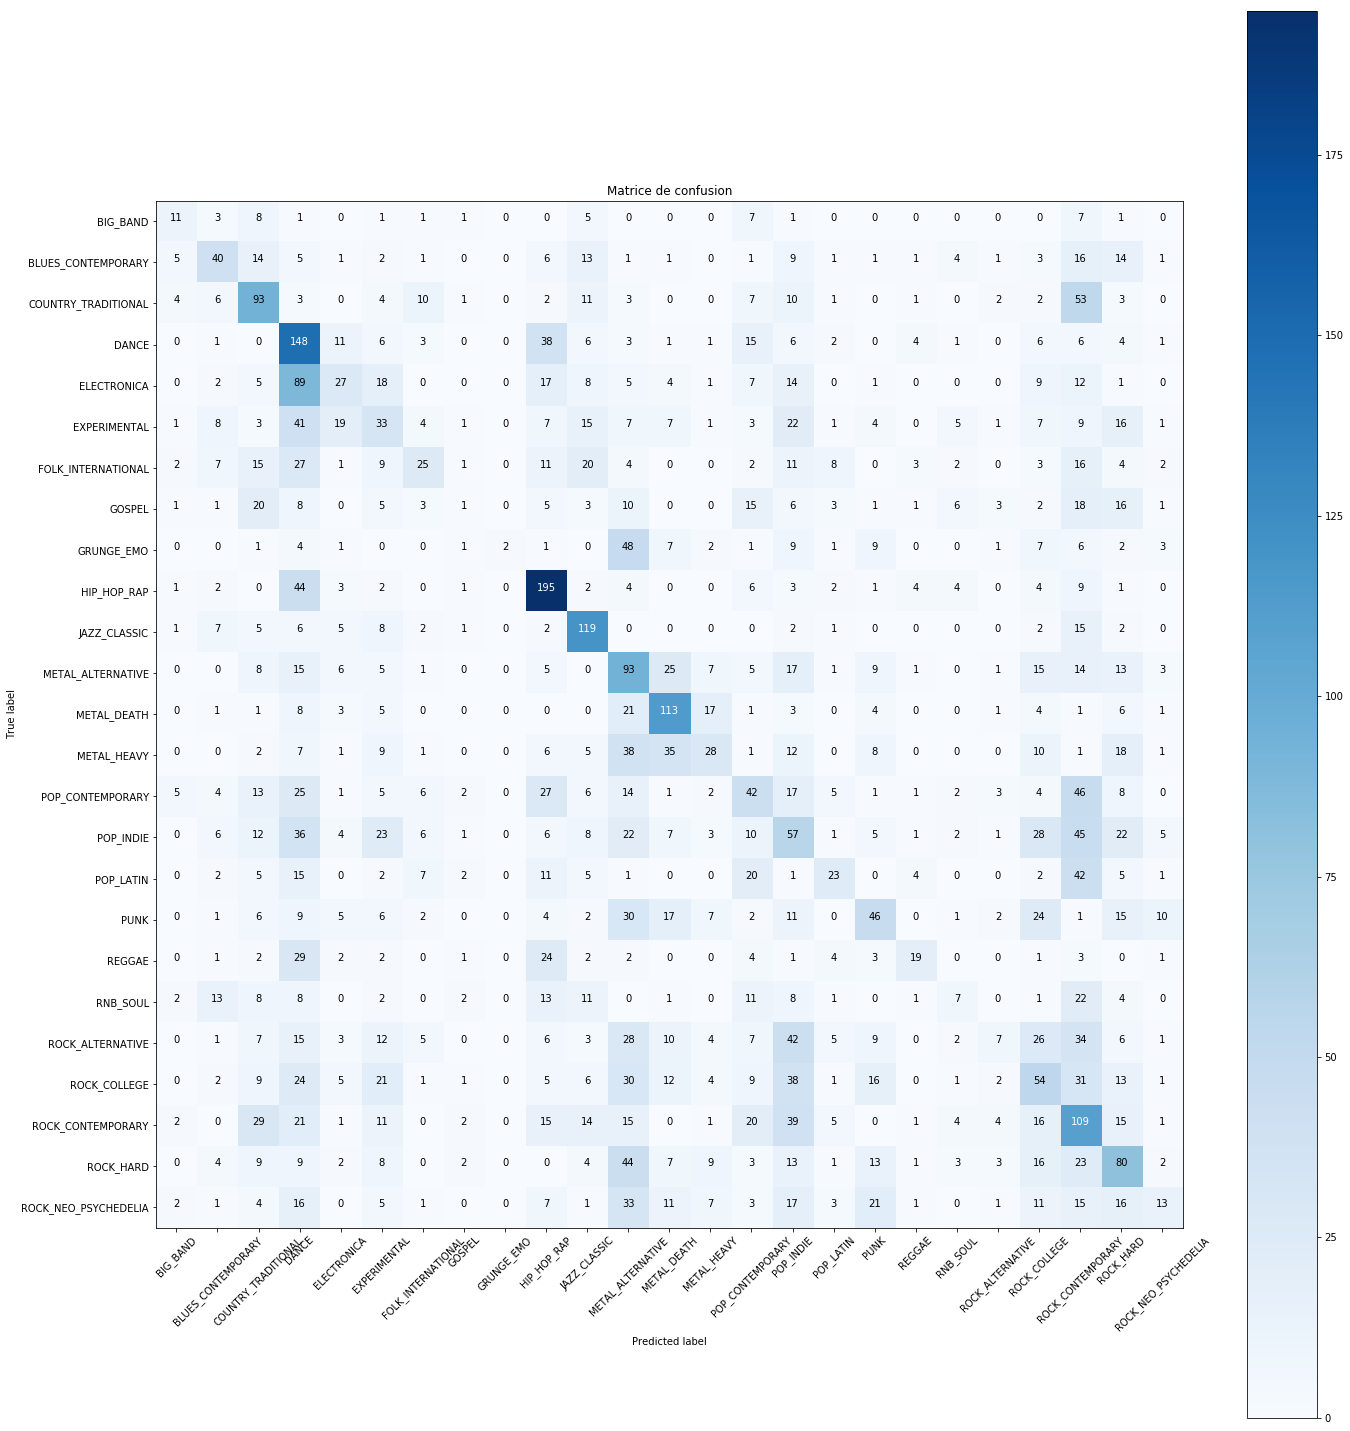

In [133]:
plot_confusion_matrix(cm_VOTE)